# Quality Control Example 
## using methylprep and methylcheck and GSE69852 from the GEO database
#### Import modules

In [1]:
import methylprep
import methylcheck
from pathlib import Path

## Importing methylprep data

- Previously, I downloaded and gunzipped raw data from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE100850&format=file.
- ABOUT GSE100850: Epigenetic alterations detected in the genome of very young breast cancer patients:
  - identification of new biomarkers 

#### using `methylprep`, I generated a file called "beta_values.pkl" this way:

    idat_dir = "/GSE100850_RAW"
    df = methylprep.run_pipeline(idat_dir, betas=True)
    makes df into a betas sheet. (the consolidate function within it)

Then I loaded the data from disk, like this:

In [2]:
df = methylcheck.load(Path("~/methylcheck/docs/example_data/GSE69852/").expanduser())

Files: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
INFO:methylcheck.load_processed:loaded data (485512, 6) from 1 pickled files (0.141s)


## Filtering functions
To autodetect the array type, use `methylcheck.detect_array(df)`. Names for arrays include `('450k','epic','mouse','27k','epic+')`

In [3]:
print(methylcheck.detect_array(df))
df.shape

450k


(485512, 6)

## Exclude X and Y chromosome probes

In [4]:
df = methylcheck.exclude_sex_control_probes(df, 'EPIC', verbose=True)
df.shape

Array EPIC: Removed 19627 sex linked probes and 695 internal control probes from 6 samples. 474929 probes remaining.
Discrepancy between number of probes to exclude (20322) and number actually removed (10583): 9739
This happens when probes are present multiple times in array, or the manifest doesn't match the array (EPIC).


(474929, 6)

Oops, you'll see an error message if you specify the wrong array type. Try again.

In [5]:
df = methylcheck.exclude_sex_control_probes(df, '450k', verbose=True)
df.shape

Array 450k: Removed 11648 sex linked probes and 916 internal control probes from 6 samples. 473864 probes remaining.
Discrepancy between number of probes to exclude (12564) and number actually removed (1065): 11499
This happens when probes are present multiple times in array, or the manifest doesn't match the array (450k).


(473864, 6)

### next, remove all probes that researchers have deemed inreliable

In [7]:
sketchy_probes = methylcheck.list_problem_probes('EPIC')
filtered = methylcheck.exclude_probes(df, sketchy_probes)

Of 473864 probes, 186571 matched, yielding 287293 probes after filtering.


## QC plots
`sample_plot` and `beta_density_plot` show probe beta values for each sample as a separate trace.
(`sample_plot` is an alias for `beta_density_plot`)

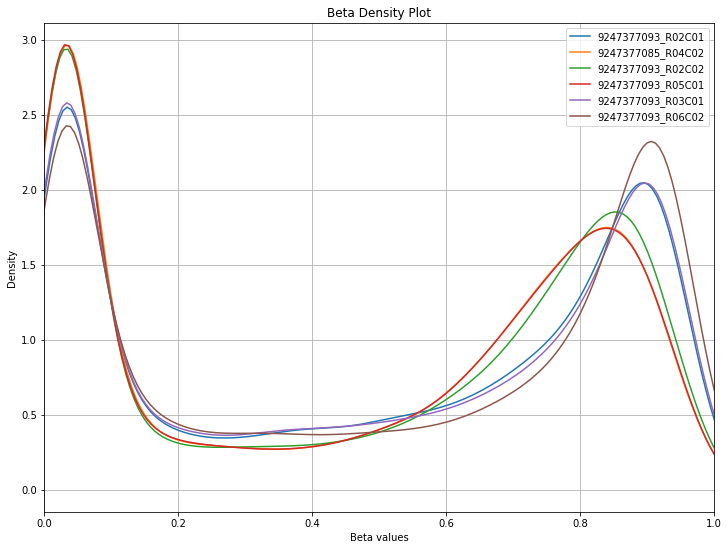

In [10]:
methylcheck.beta_density_plot(df)

#### This shows all samples as a single trace.

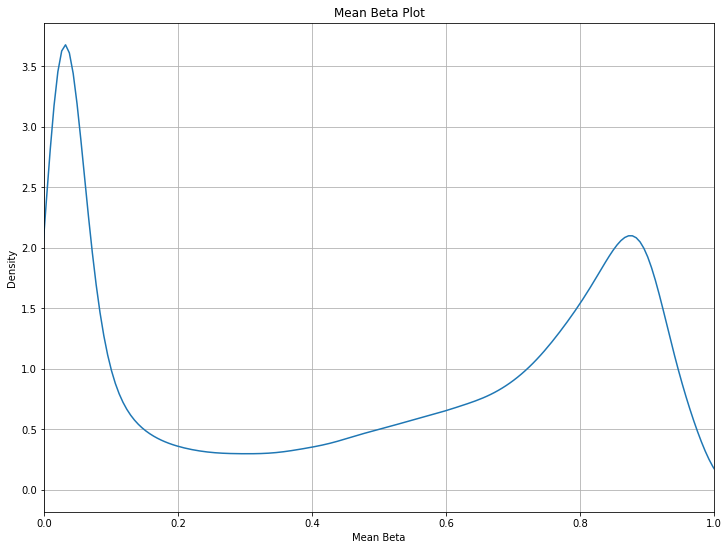

In [11]:
methylcheck.mean_beta_plot(df)

## Visual filtering functions
(These return a filtered data set)

### MDS filtering 
 - you can exclude outlier samples based on falling outside 
 - some standard deviation cutoff from the center of a 2D plot.
 - This is an interactive function.

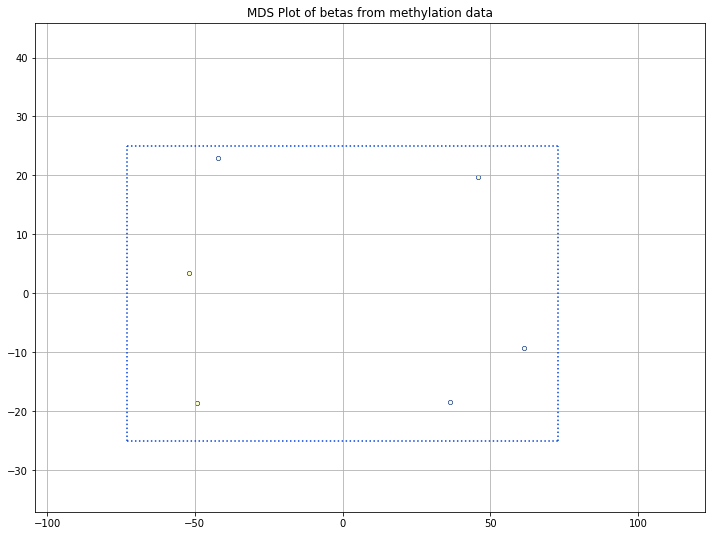

6 original samples; 6 after filtering
Your scale factor was: 1.5
Enter new scale factor, <enter> to accept and save: 


In [14]:
mds_filtered = methylcheck.beta_mds_plot(df)

0it [00:00, ?it/s]

Calculating area under curve for each sample.


6it [00:01,  3.90it/s]


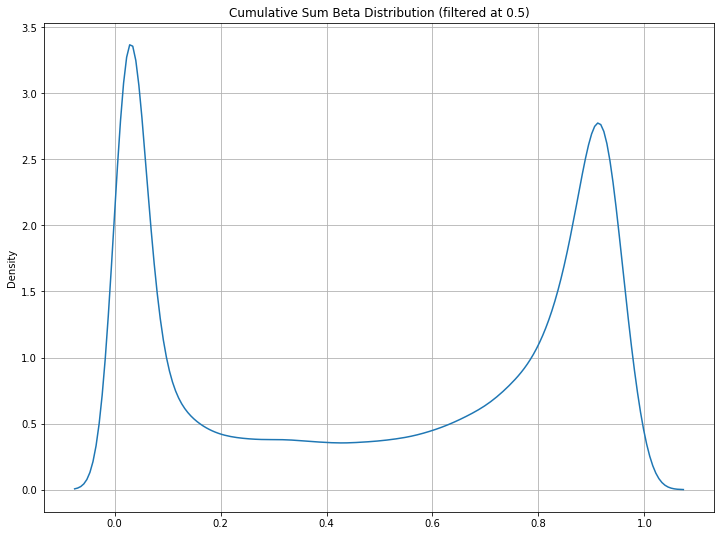

In [15]:
# adjust the cutoff value to exclude outliers. Default is 0.7.
df_outliers_removed = methylcheck.cumulative_sum_beta_distribution(mds_filtered, cutoff=0.5)

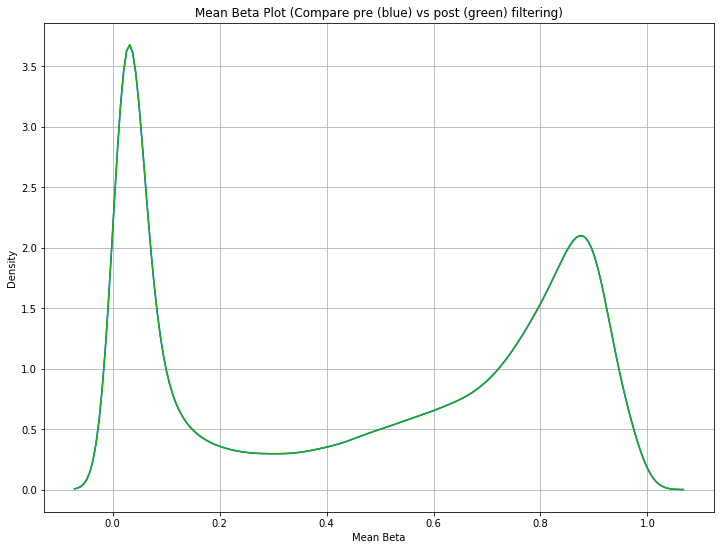

In [16]:
# effect of MDS filtering
methylcheck.mean_beta_compare(df, mds_filtered)

INFO:methylcheck.samples.postprocessQC:Your data needed to be transposed (df = df.transpose()).


Your second data set needed to be transposed (df = df.transpose()).


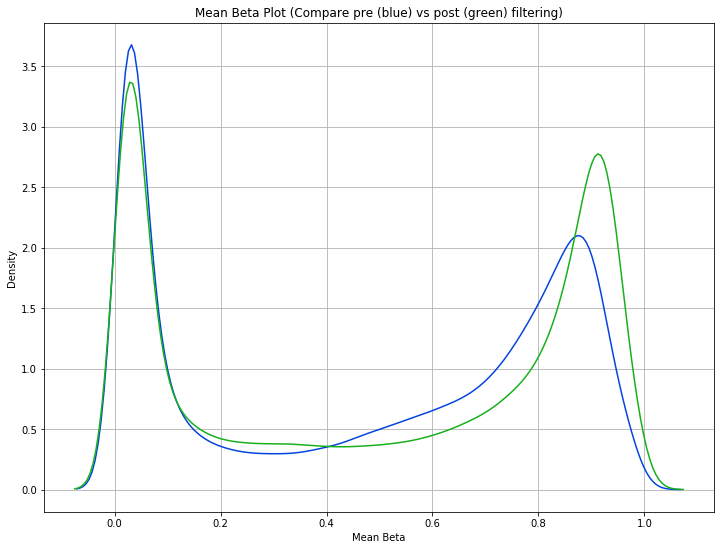

In [17]:
# effect of cumulative sum filtering
methylcheck.mean_beta_compare(df, df_outliers_removed, verbose=True)

## Analysing Control Probes
The `run_qc()` function is covered more extensively elsewhere, but you can use one function to analyze all of the control probes for any array as a series of QC plots.

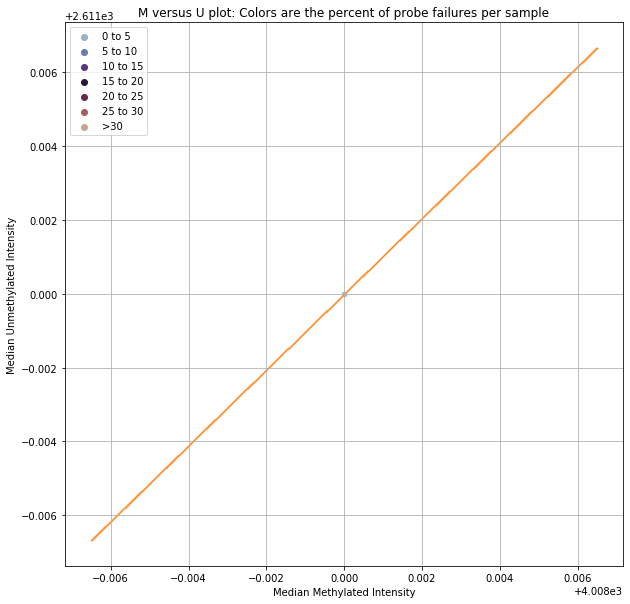

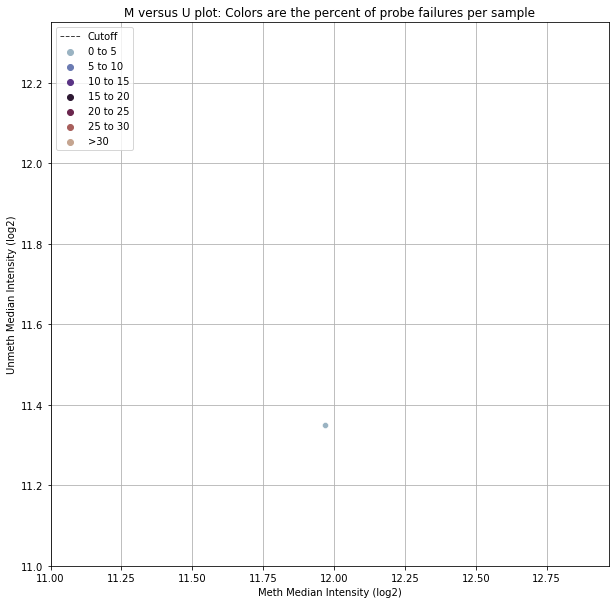

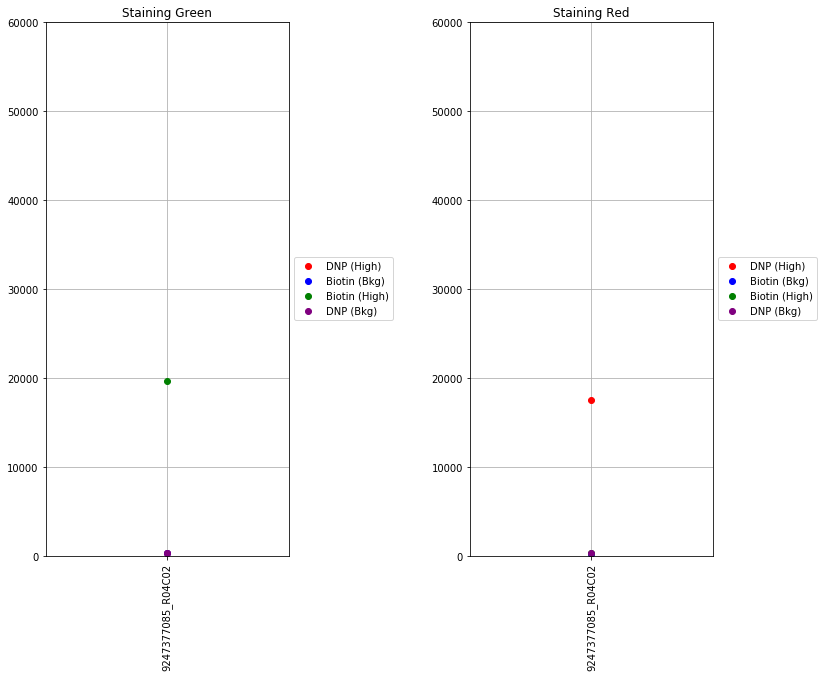

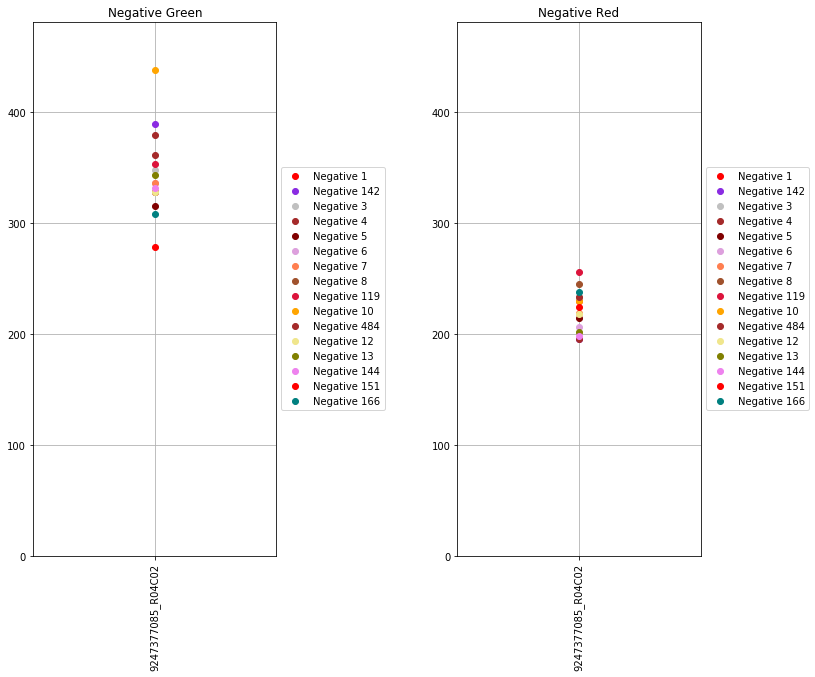

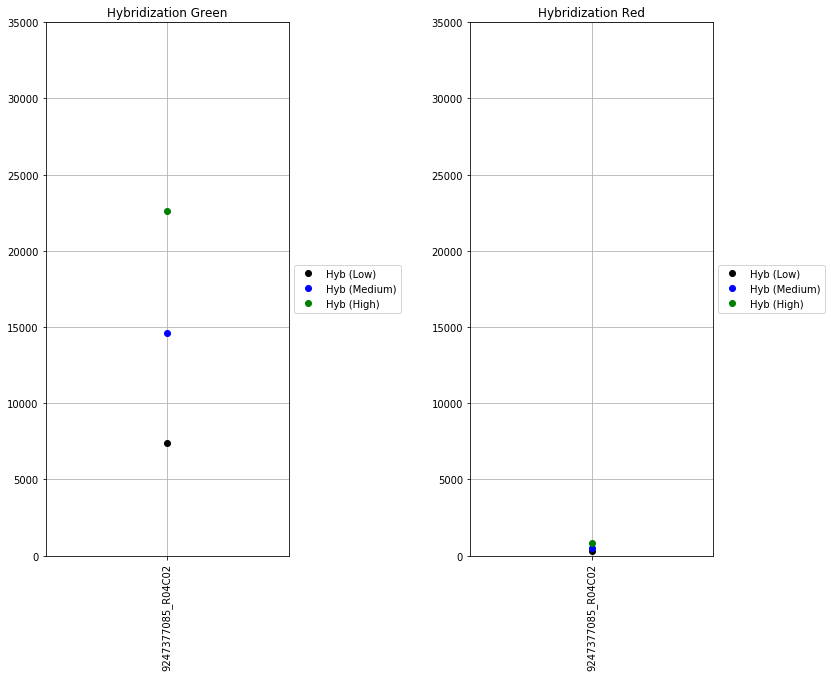

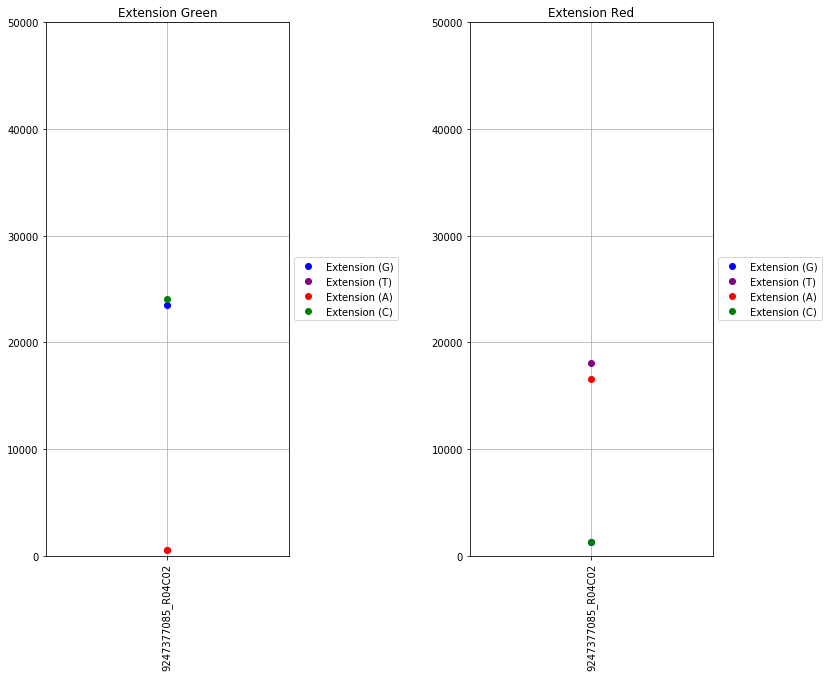

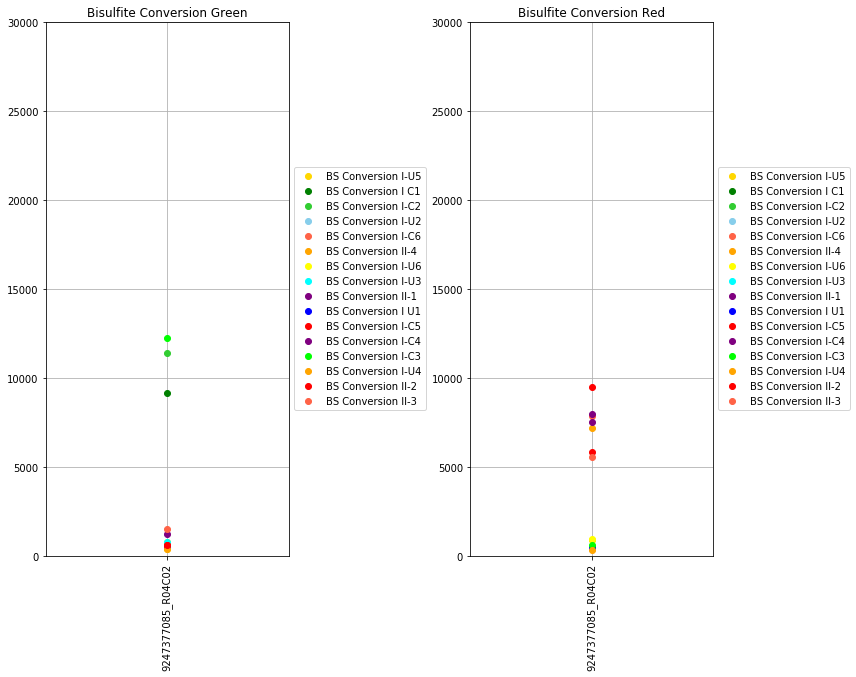

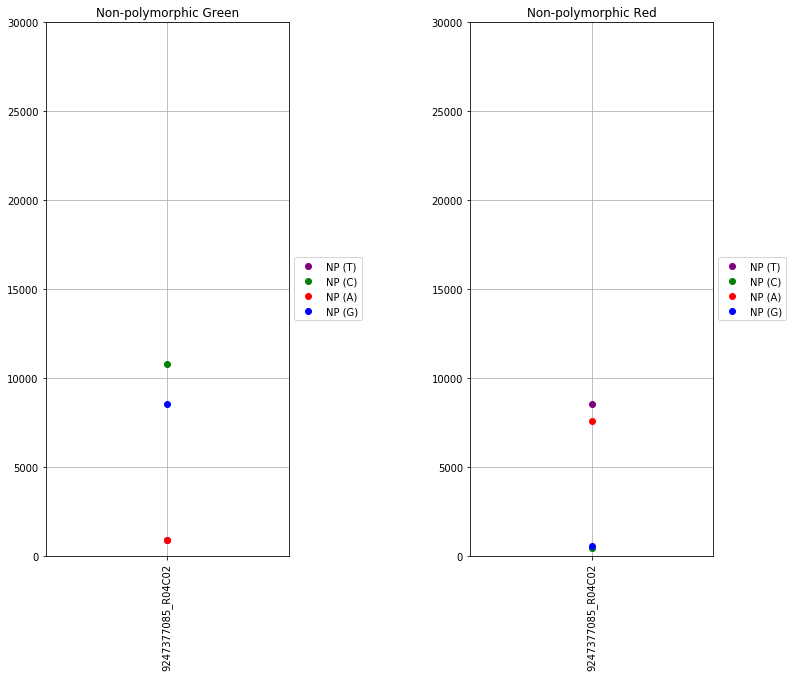

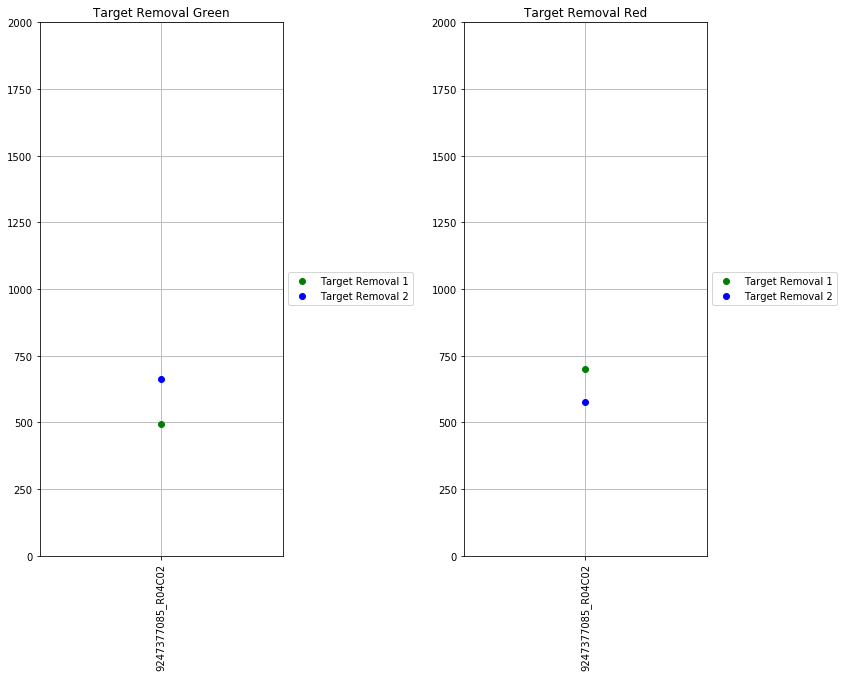

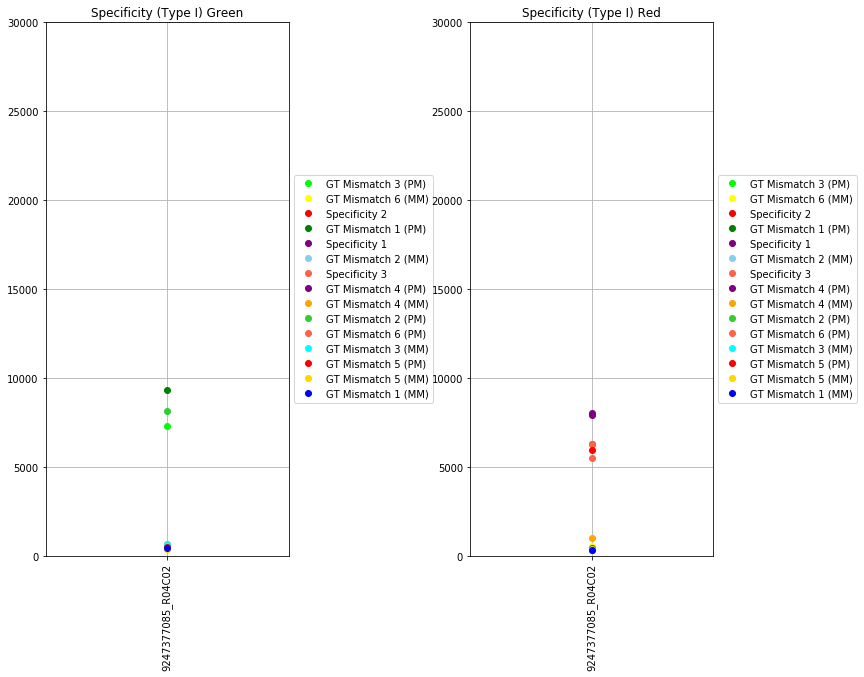

INFO:methylprep.files.manifests:Reading manifest file: HumanMethylation450_15017482_v1-2.CoreColumns.csv


Found 135476 type I probes.


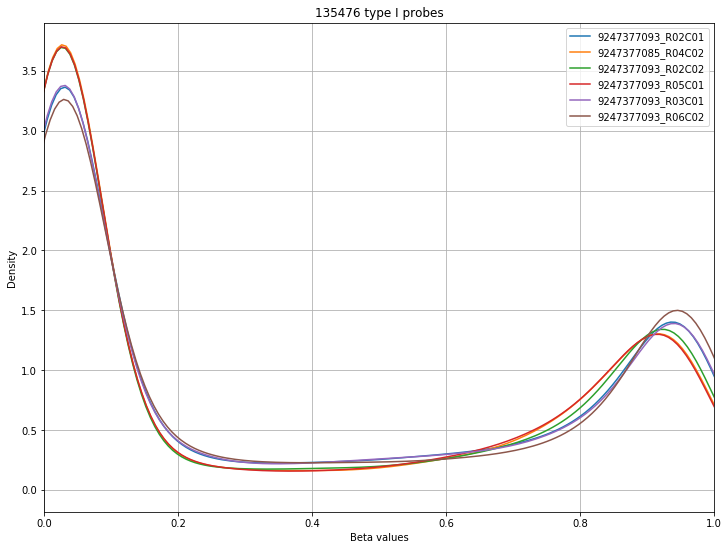

Found 350036 type II probes.


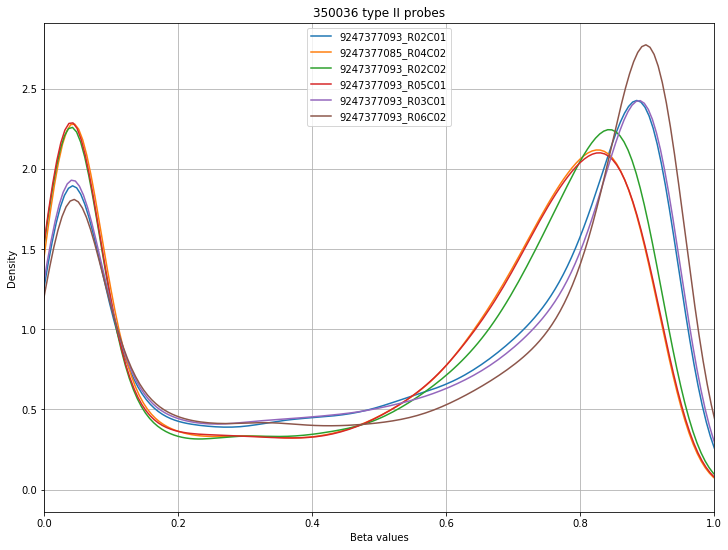

Found 89187 type I Red (IR) probes.


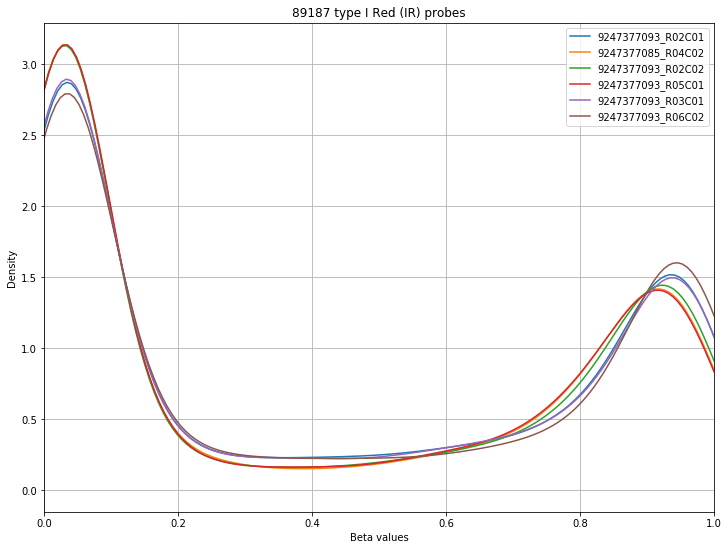

Found 46289 type I Green (IG) probes.


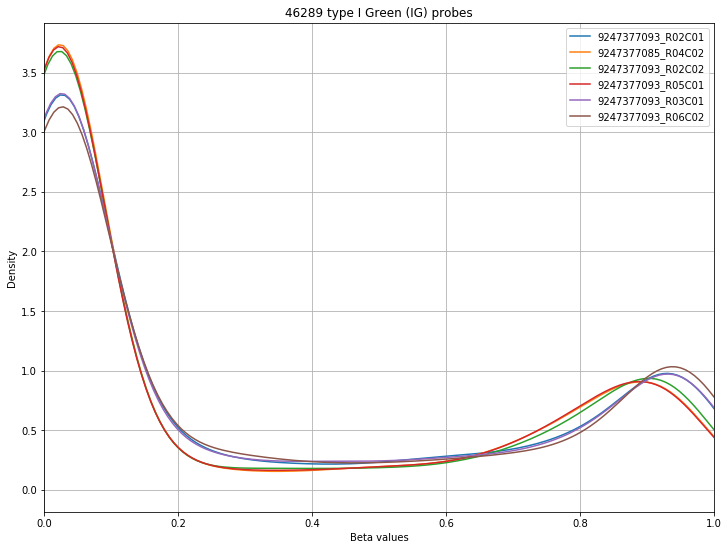

In [12]:
# This test file only has ONE sample, but with a large batch, outliers will become more apparent.
filepath = Path("~/methylcheck/docs/example_data/GSE69852/").expanduser()
methylcheck.run_qc(filepath)